# Milestone 5

As machine learning becomes more powerful, we see its use in an ever increasing number of fields, from language translation all the way to video generation. For our project, we wish to explore the possibility of using deep learning architectures learned throughout the semester to generate new music. 


<a id="contents"></a>

## Notebook Contents

- [1. Problem Statement](#part1)
- [2. Exploratory Data Analysis](#part2)
- [3. Baseline Model](#part3)
- [4. Final Model](#part4)
- [5. Future Work and Improvement](#part5)

We were given two possible datasets: (1) MAESTRO and (2) Lakh, both of which contain hours of music in the form of MIDI files. Given the small dataset size and limited project scope to classical piano music of the Maestro dataset, we ultimately chose to pursue analysis of the Lakh dataset, which consists of a wider range of musical styles and artists. 

<a id="part1"></a>
# 1. Problem Statement

To start, our project sought to utilize musical features (such as tempo, key signature, and note density) to create a machine learning model that is able to accurate generate new MIDI music. 

Thus, our problem statement is: Given the distribution of defining musical features (such as tempo, key signature, and note density) within music, how are we able to craft a machine-learning model that accurately generates new MIDI music?

We decided to use the Lakh dataset (https://colinraffel.com/projects/lmd/) because it had a wider range of musical genres and artists the model could train on compared to the Maestro dataset.

Based on our thorough exploration of the data, with more information on this below, our revised project question remains generally consistent. However, as our training datasets are primarily encompassed with $\texttt{pop}$ genre music, we seek to answer said question, but in the context of $\texttt{pop}$ .

## Imports

In [1]:
# install packages
%pip install pretty_midi librosa tables music21

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tables
import IPython.display
import os
import json
import tarfile
import random 
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import layers
from keras import losses
from keras import optimizers
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, TimeDistributed, Bidirectional, Dense, RNN
from keras.layers import  BatchNormalization, Activation, Dropout, GaussianNoise
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
import pretty_midi
import librosa
from music21 import converter, note, chord
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import os
from collections import Counter
# from google.colab import drive

2025-05-09 18:43:34.513442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 18:43:34.513491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 18:43:34.514234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 18:43:34.518988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Above we have a series of imports that we will be utilzing for this project. In addition to this, we print the size of our dataset in order to understand the weight of our selected dataset. We ultimately find the dataset to be a hefty one, with 17,256 MIDI files (each file representative of a data entry).

In [3]:
# Mount google drive
# drive.mount('/content/drive')

# Open TAR file data from the cleaned dataset
tar = tarfile.open('data/clean_midi.tar')

# Collect file names
file_names = np.array(tar.getnames()[1:])
mask = ['.mid' in x for x in file_names]
indices = np.where(mask)[0]
file_names = file_names[indices]

# Print number of MIDIs in dataset
print(f'There are {len(file_names)} MIDI files in the cleaned dataset.')
print(file_names)

There are 17256 MIDI files in the cleaned dataset.
['clean_midi/Hugues Aufray/Celine.mid'
 'clean_midi/Linda Ronstadt/When Will I Be Loved.mid'
 "clean_midi/Linda Ronstadt/You're No Good.mid" ...
 'clean_midi/Haddaway/What Is Love.mid'
 'clean_midi/Haddaway/What Is Love.4.mid'
 "clean_midi/Alpenrebellen/Die Leut' am Land.mid"]


In [4]:
# Extraction folder path
extract_path = "extracted_midi"

# Check if folder exists
if not os.path.exists(extract_path):
    print("Extracting MIDI files with folder structure preserved...")

    os.makedirs(extract_path, exist_ok=True)

    with tarfile.open("data/clean_midi.tar", "r") as tar:
        # Only include MIDI files
        midi_members = [m for m in tar.getmembers() if m.name.endswith(".mid")]
        
        # Extract with folder structure
        tar.extractall(path=extract_path, members=midi_members)
    print(f"Extraction complete. {len(midi_members)} MIDI files saved to '{extract_path}'.")

else:
    print(f"Folder '{extract_path}' already exists. Skipping extraction.")

Folder 'extracted_midi' already exists. Skipping extraction.


Above, we simply extract our dataset, while maintaining its given folder structure.

<a id="part2"></a>
# 2. Exploratory Data Analysis

In [5]:
# Updated path to where it's now stored
file_path = "extracted_midi/clean_midi/Haddaway/What Is Love.mid"

# Use converter to find key
midi_file = converter.parse(file_path)
key = midi_file.analyze('key')
print(f"Key: {key}")

Key: B major


We use the $\texttt{Music21}$ to find the corresponding musical key for each song in the $\texttt{Cleaned Lakh Dataset}$.

,filename,genre
0,"10,000 Maniacs/A Campfire Song",Alternative rock
1,101 Strings/Theme From The Godfather,Pop
2,10cc/Dreadlock Holiday,Reggae rock
3,10cc/I'm Not In Love,Soft rock
4,10cc/The Things We Do for Love,Soft rock


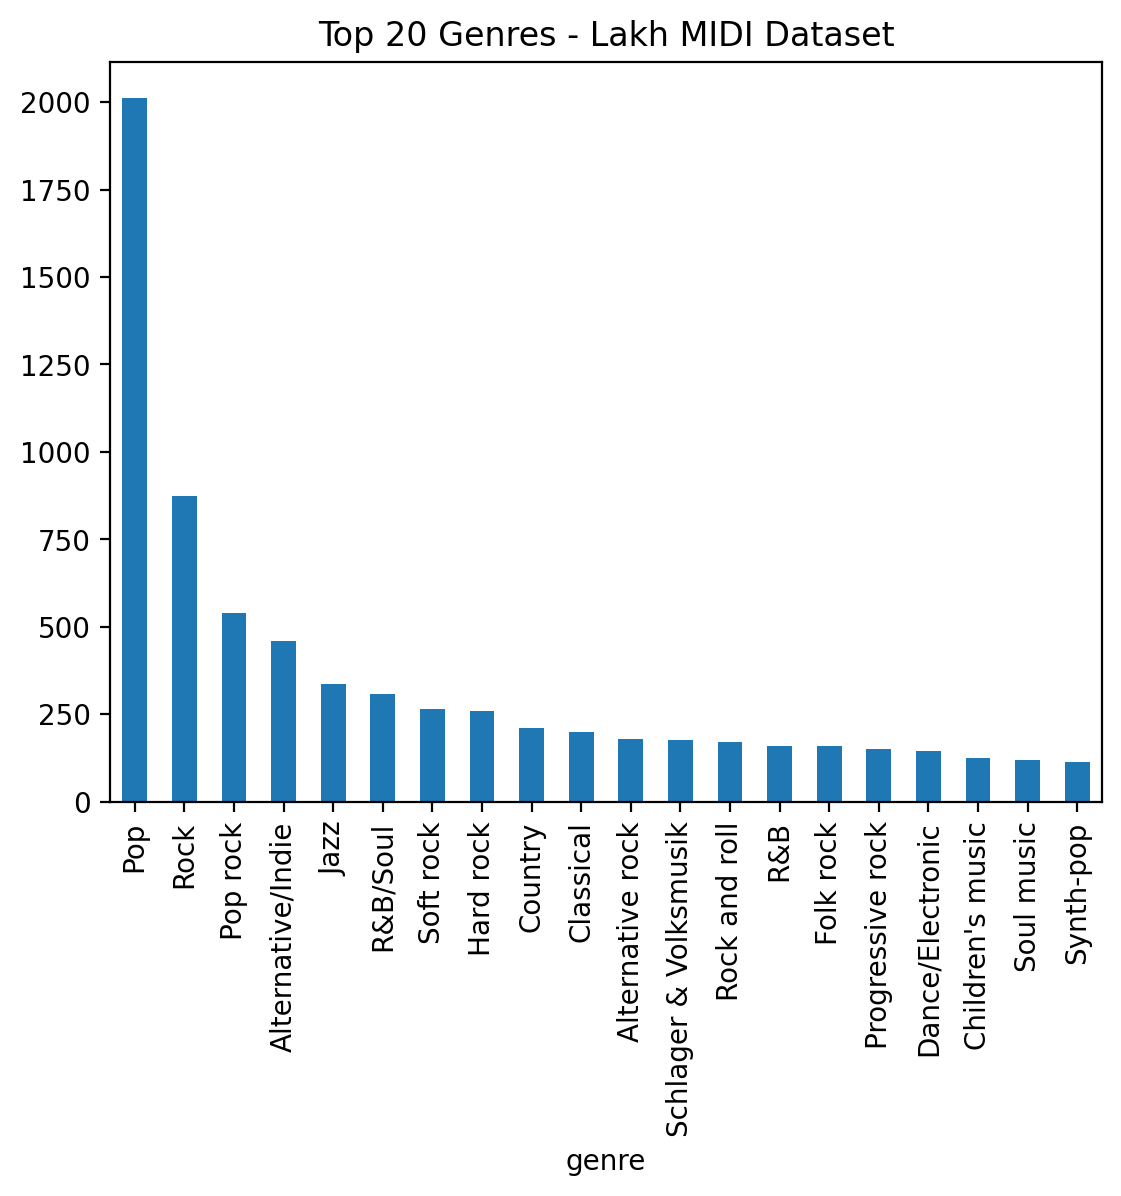

In [6]:
# Match each MIDI file to its corresponding genre
genres_df = pd.read_csv('data/genre.tsv', sep='\t')
incorrect_cols = genres_df.columns # read_csv makes the first row of the tsv file as the column of the dataframe
genres_df = genres_df.rename(columns={incorrect_cols[0]:'filename', incorrect_cols[1]: 'genre'})

# Append the incorrect columns into the dataframe
genres_df.loc[len(genres_df)] = incorrect_cols
display(genres_df.head())

# Create histogram charting frequency of the top most frequent genres in dataset
genres_df['genre'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Genres - Lakh MIDI Dataset')
plt.show()

We utilize the $\texttt{Genres Dataset}$, a genre-matched subset of data from the cleaned Lakh dataset. The analysis from the plot above shows that our dataset primarily contains $\texttt{Pop}$ music, with almost 2000 songs being categorized as said genre. There are approximately 800 songs in the genre of $\texttt{Rock}$, 500 songs in $\texttt{Pop rock}$, 450 songs in $\texttt{Alternative/Indie}$ and 300 songs in $\texttt{Jazz}$.

In [7]:
# Function to extract time signature, tempo, and the number of notes from MIDI
def extract_meta_data(file_name):
    file_path = os.path.join("extracted_midi", file_name)

    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)

        # Get time signature
        if midi_data.time_signature_changes:
            ts = midi_data.time_signature_changes[0]
            time_signature = f"{ts.numerator}/{ts.denominator}"
        else:
            time_signature = None

        # Calculate tempo (halve value to correctly estimated – double-time issue)
        tempo = midi_data.estimate_tempo() / 2

        # Calculate total number of notes
        num_notes = sum(len(inst.notes) for inst in midi_data.instruments)

        # Find key signatures are completely optional meta-event – many MIDI files don't have this information
        if midi_data.key_signature_changes:
            key_signature = midi_data.key_signature_changes[0].key_number
        else:
            key_signature = None

        # Get duration
        if midi_data.get_end_time():
            duration = midi_data.get_end_time()
        else:
            duration = None
        
        return time_signature, tempo, key_signature, num_notes, duration

    except Exception as e:
        return None, None, None, None, None

# Arrays to store the found
time_signatures = []
tempos = []
key_signatures = []
num_notes = []
song_duration = []

# Set seed and also shuffle the data
random.seed(109)
shuffled_file_names = np.random.permutation(file_names)

for file_name in shuffled_file_names[:1000]:
  time, tempo, key, notes, duration = extract_meta_data(file_name)
  time_signatures.append(time)
  tempos.append(tempo)
  key_signatures.append(key)
  num_notes.append(notes)
  song_duration.append(duration)

# Remove entries with for each list
key_signatures = [key for key in key_signatures if key is not None]
time_signatures = [time for time in time_signatures if time is not None]
tempos = [tempo for tempo in tempos if tempo is not None]
num_notes = [note for note in num_notes if note is not None]
song_duration = [dur for dur in song_duration if dur is not None]

print('Extraction of meta-data complete')

/shared/home/dap6224/.local/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Extraction of meta-data complete


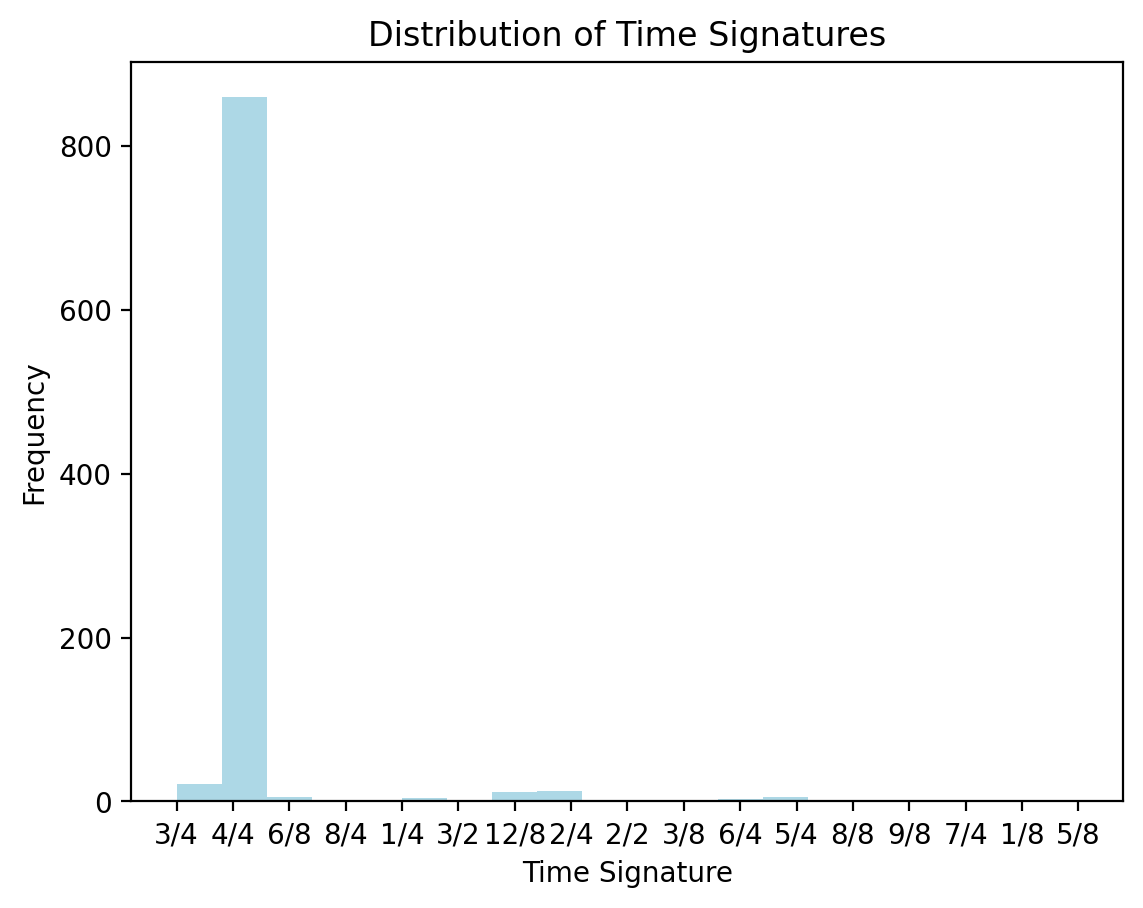

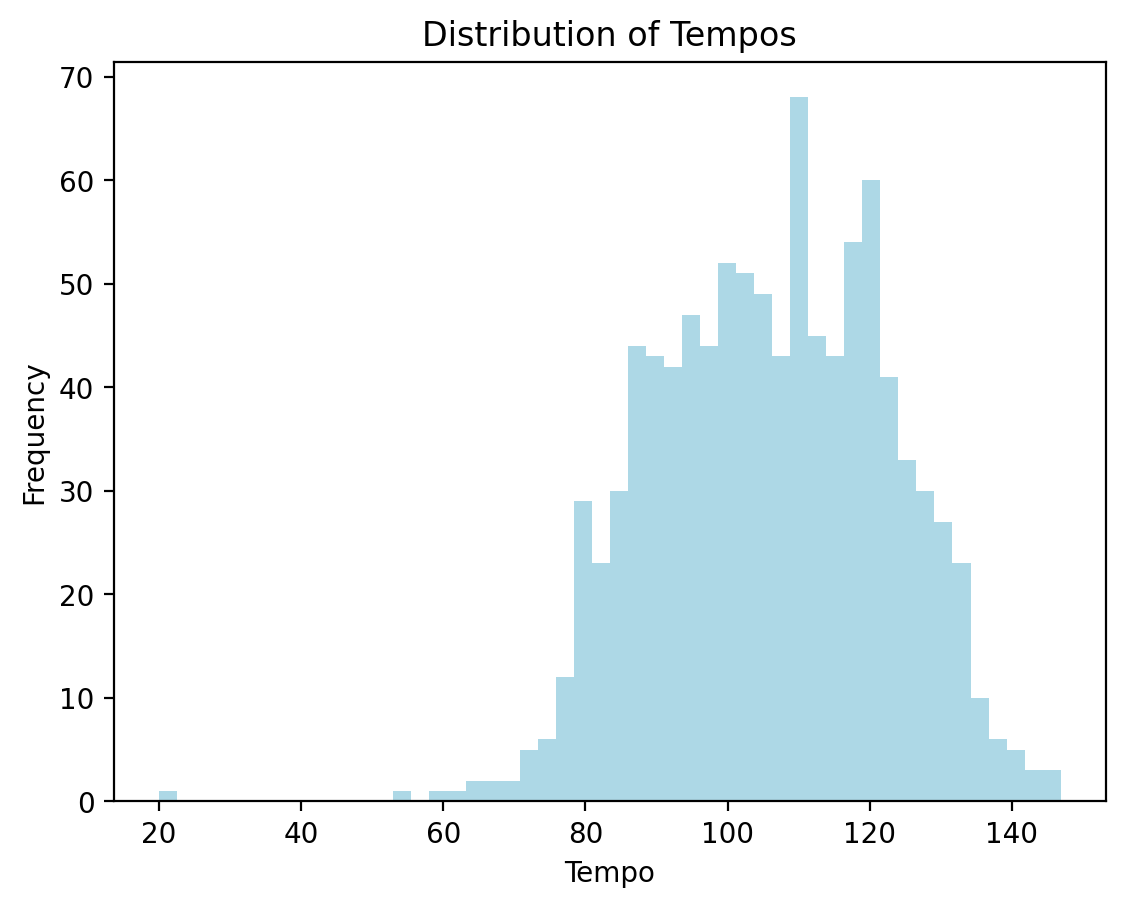

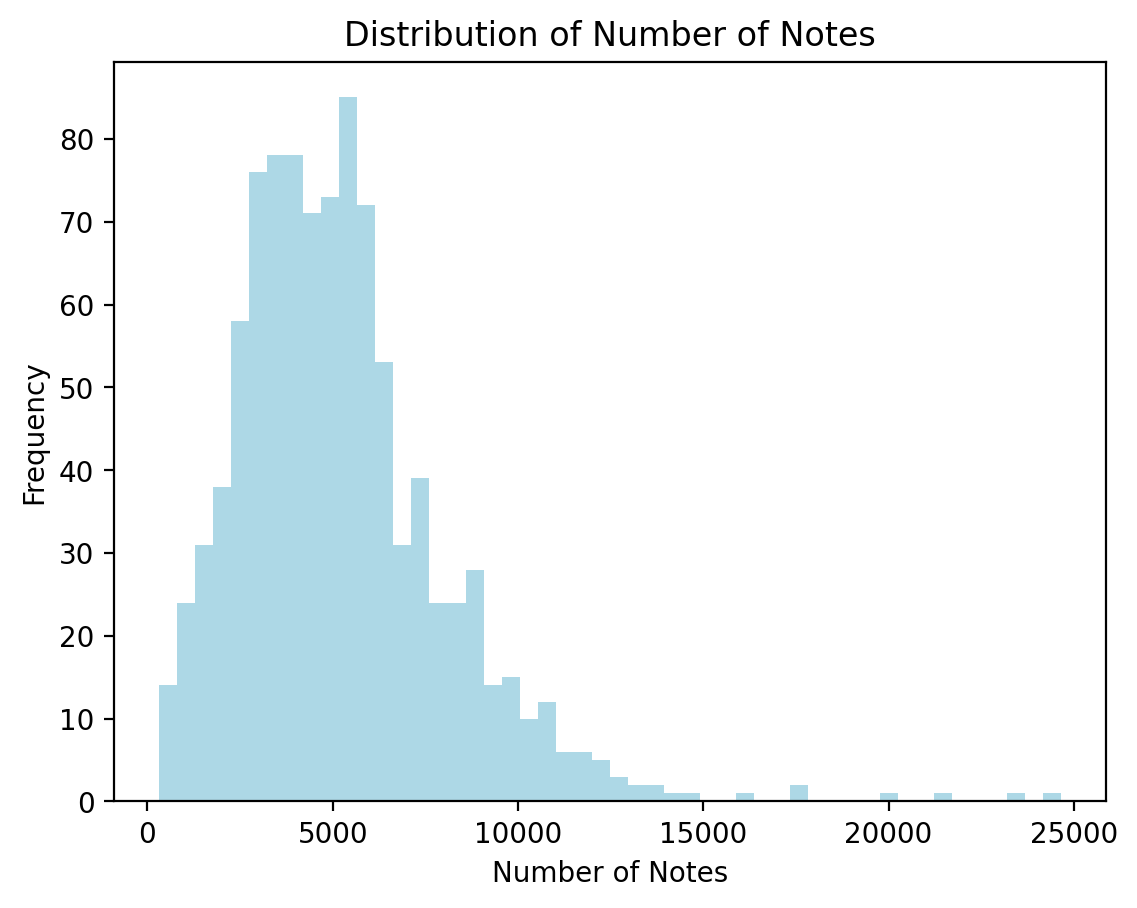

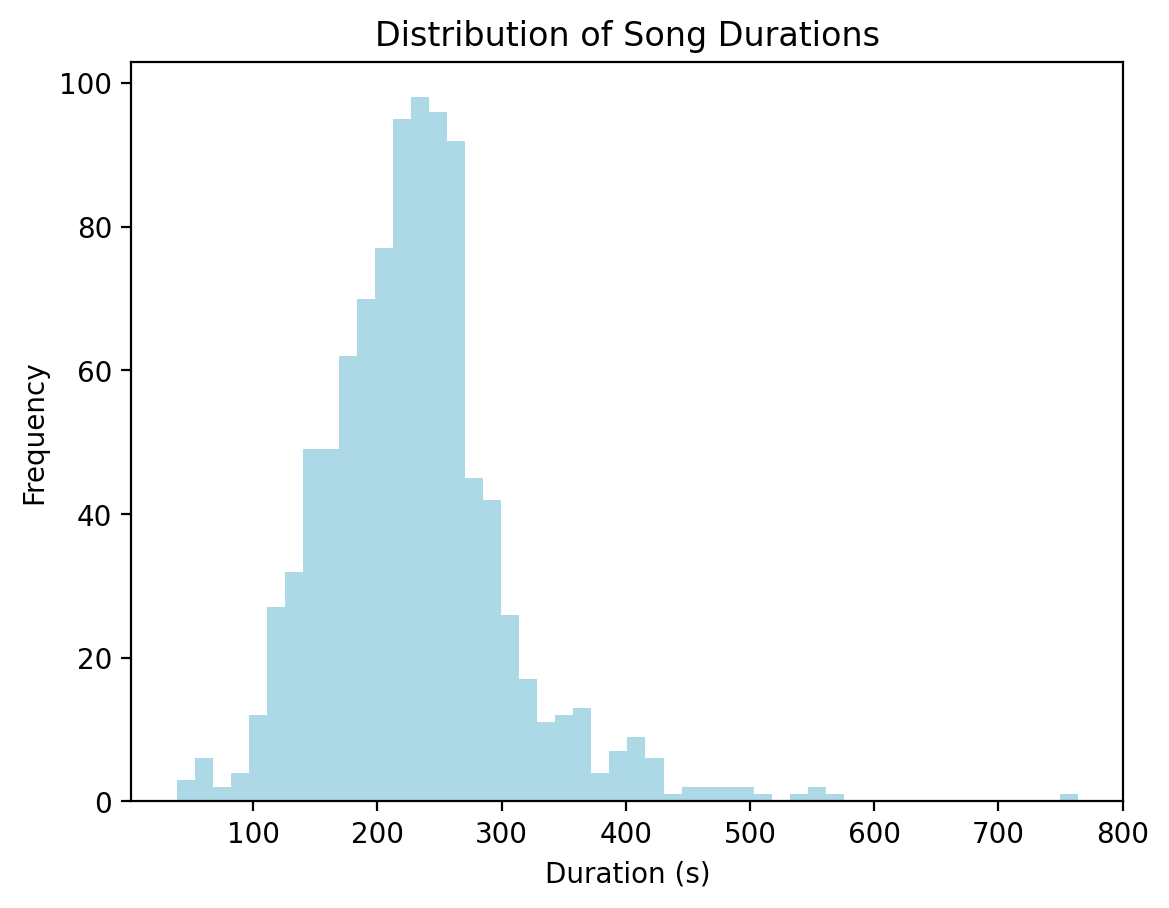

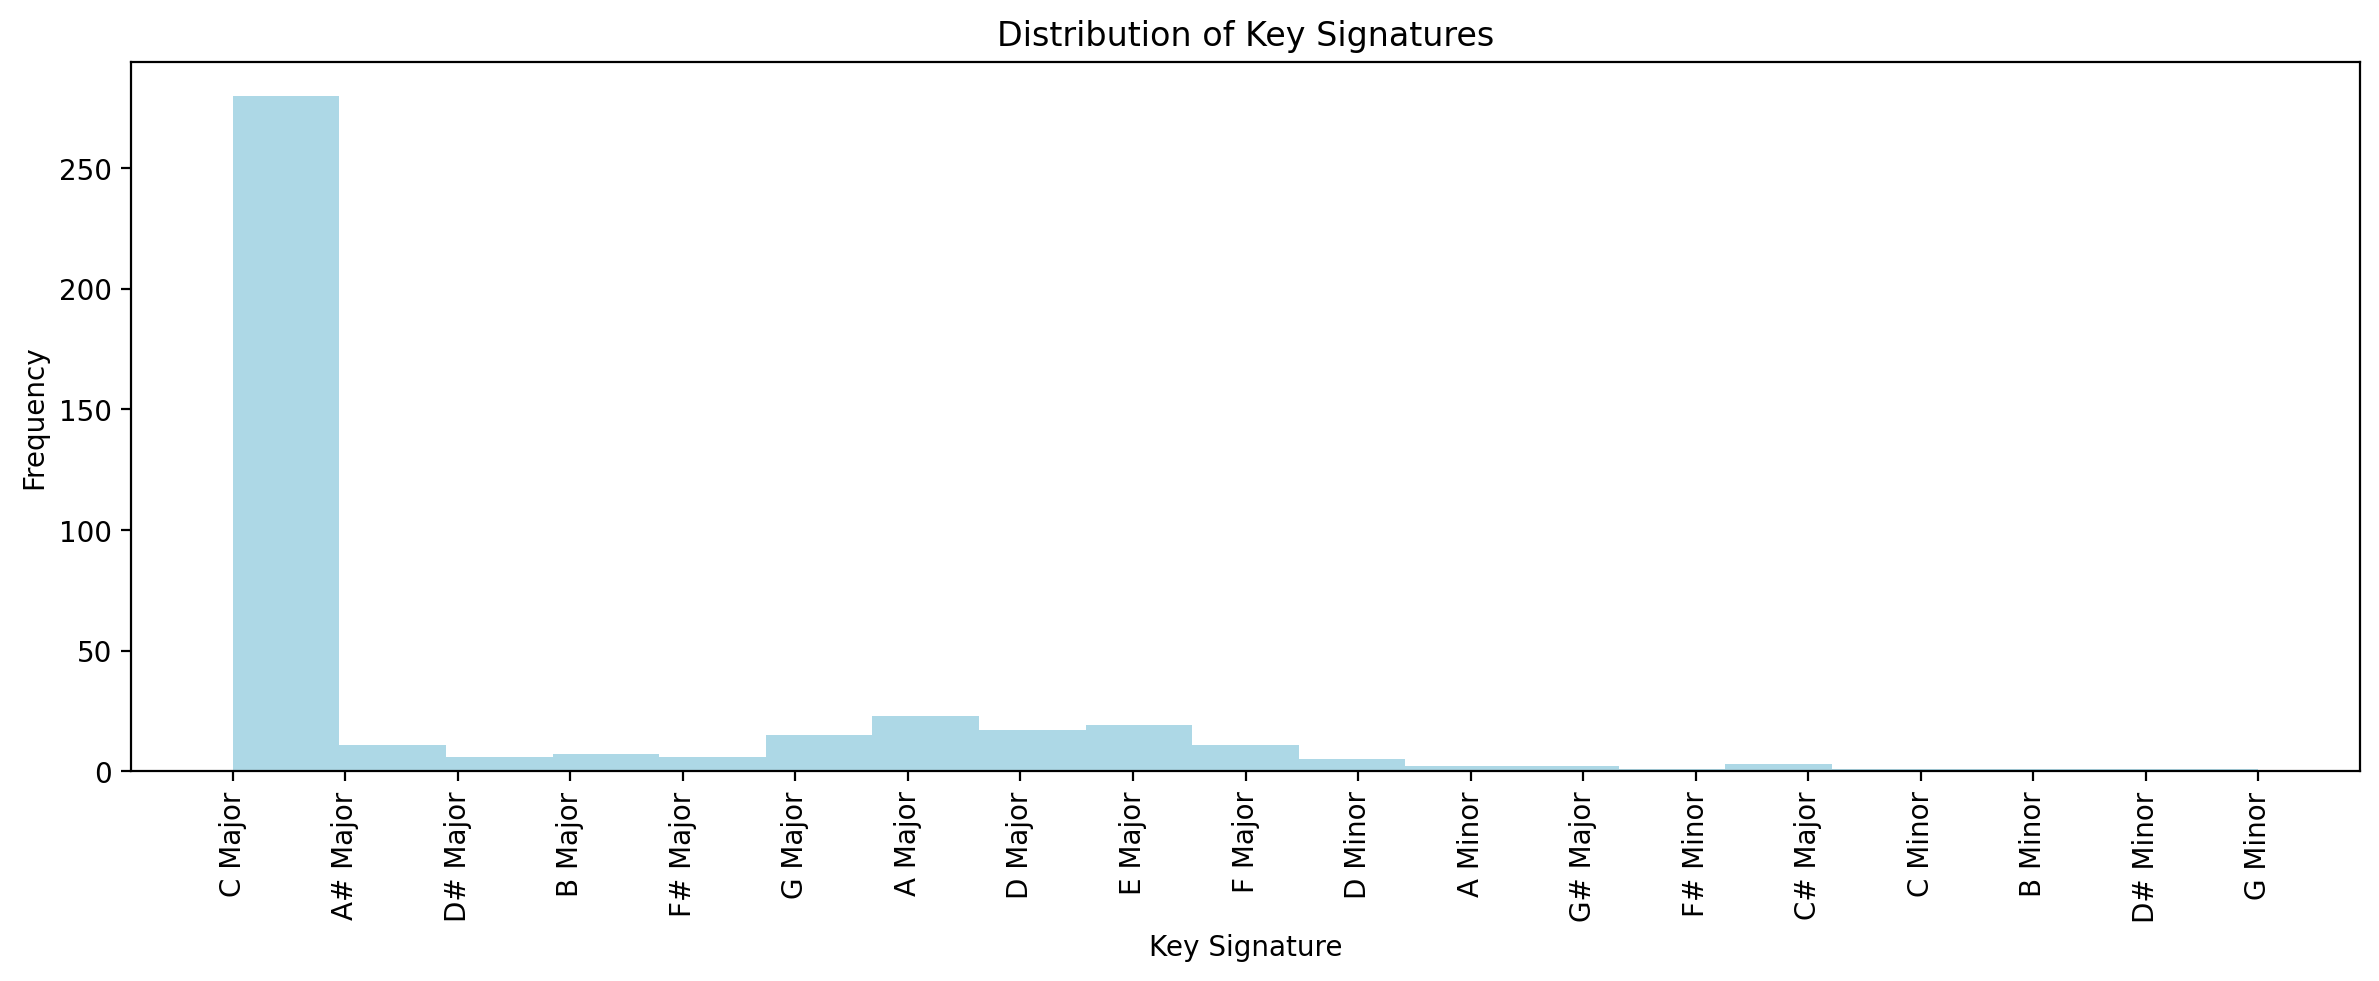

In [8]:
# Plot histogram of time signatures
plt.hist(time_signatures, bins=20, color='lightblue')
plt.title('Distribution of Time Signatures')
plt.xlabel('Time Signature')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of tempos
plt.hist(tempos, bins=50, color='lightblue')
plt.title('Distribution of Tempos')
plt.xlabel('Tempo')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of notes
plt.hist(num_notes, bins=50, color='lightblue')
plt.title('Distribution of Number of Notes')
plt.xlabel('Number of Notes')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of duration
plt.hist(song_duration, bins=50, color='lightblue')
plt.title('Distribution of Song Durations')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of key signatures

# Mapping from key_number to musical key name
key_number_to_name = {
    0: "C Major",   1: "C# Major",  2: "D Major",   3: "D# Major",
    4: "E Major",   5: "F Major",   6: "F# Major",  7: "G Major",
    8: "G# Major",  9: "A Major",  10: "A# Major", 11: "B Major",
    12: "C Minor", 13: "C# Minor", 14: "D Minor", 15: "D# Minor",
    16: "E Minor", 17: "F Minor", 18: "F# Minor", 19: "G Minor",
    20: "G# Minor",21: "A Minor", 22: "A# Minor", 23: "B Minor"
}

# Convert numeric keys to musical names using the dictionary
key_names = [key_number_to_name[k] for k in key_signatures if k in key_number_to_name]

# Plot as categorical histogram
plt.figure(figsize=(12, 5))
plt.hist(key_names, bins=len(set(key_names)), color='lightblue')
plt.title('Distribution of Key Signatures')
plt.xlabel('Key Signature')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Above, we have utilized the $\texttt{Pretty\_MIDI}$ library and our custom function to extract the time signatures, tempo, and key of each song within our dataframe for 1000 songs.

It is notable that we find that the $\texttt{Pretty\_MIDI}$ library actually interprets every song's tempo in double-time. This is found to be consistent and in line with other users of this library as well. Thus, we chose to divided the found tempo by two to ensure the correct single time metric.

As the dataset is rather large and thus computationally expensive to run, we have randomly shuffled our data and selected to determine the distributions of the data based on the first 1000 songs of the dataset. By shuffling, we ensure that our data is able to be generalizable toward the greater dataset.

From our Time Signature plot, we find that the vast majority of songs are in $\frac{4}{4}$ with a couple of outlier songs in other time signatures. Based on this plot, we will train a model to generate songs in $\frac{4}{4}$ timing as well.

From our song distributions plot, we find an overwhelming range of song durations; this is most likely due to the variety of genres in the music the dataset. The median of song length seems to fall around the 4 minute mark, which makes sense considering the majority of our data consists of pop songs, which are generally between 3 to 5 minutes. We did not think of using this the duration until after we finishing milestone 3. We will incorporate the duration into our training from here onward.

Analyzing the distribution of tempos, we find a bimodal graph normal distribution with peaks at the 90 BPM and 120 BPMmark, low points around the 60 BPM mark, and high points around the 140 BPM mark. This shows that the majority of our songs are more upbeat with faster tempos. This aligns with our finding that the majority of songs in this dataset are under the $\texttt{Pop}$ genre.

Furthermore, we analyzed the number of notes played within each song. We sought to use this to infer the optimal length of each song. We notice a normal distribution with a mean peak at approximately 5000, with a lower bound of 100, and an upper bound of approximately 17,500 notes. Said distribution is found to be especially right-skewed past the 10,000 marking as well. While we were initially planning on using this data to infer the duration of the typical song, we soon realized that tempo, signature and other variables make this a poor indicator of duration. We need to pivot from this and find a better way to calculate the duration of each song with the end time stamp of each MIDI file. This will be utilized in the final model.

Finally, for key signatures, we find that the vast majority of songs are in the key of $\texttt{C Major}$. This is in line with the fact that the majority of our songs are popsongs. When training our songs, we may choose to train our model specifically on songs in $\texttt{C Major}$ to ensure maximal accuracy.

In [ ]:
# Function to filter data - only C Major/A Minor, 4/4 Time, 90-120 BPM
def filter_midi_files(folder_path):
    filtered_files = []

    # Find files that are relevant
    for filename in folder_path:
        # print(filename)
        if filename.endswith(".mid") or filename.endswith(".midi"):
            filepath = os.path.join('extracted_midi', filename)
            
            try:
                midi_data = pretty_midi.PrettyMIDI(filepath)

                # Check time signature
                time_signatures = midi_data.time_signature_changes
                if time_signatures:
                    # Check if time_signature is 4/4
                    ts = time_signatures[0]
                    if ts.numerator != 4 or ts.denominator != 4:
                        continue
                else:
                    continue

                # Check key signature
                key_signatures = midi_data.key_signature_changes
                if key_signatures:
                    # 0 = C major (in pretty_midi key mapping)
                    key = key_signatures[0].key_number
                    if key != 0 and key != 9:
                        continue
                else:
                    continue

                # Check tempo
                tempo_changes = midi_data.get_tempo_changes()
                tempos = tempo_changes[1]  # tempo values
                if tempos.size > 0:
                    avg_tempo = tempos.mean()
                    if not (90 <= avg_tempo <= 120):
                        continue
                else:
                    continue

                # If all conditions pass, keep the midi file
                filtered_files.append(filepath)

            except Exception as e:
                print(f"Error reading {filename}: {e}")
    
    return filtered_files

# Example usage
filtered_songs = filter_midi_files(file_names)
print(f"Found {len(filtered_songs)} good songs.")

Error reading clean_midi/Cabrel Francis/Encore et encore.mid: Could not decode key with 4 flats and mode 255
Error reading clean_midi/Cabrel Francis/Question d'equilibre.mid: Could not decode key with 4 flats and mode 255
Error reading clean_midi/The Beach Boys/I Get Around.2.mid: data byte must be in range 0..127
Error reading clean_midi/The Beach Boys/Good Vibrations.6.mid: data byte must be in range 0..127
Error reading clean_midi/Frank Sinatra/Summer Wind.mid: data byte must be in range 0..127
Error reading clean_midi/Us3/Cantaloop.1.mid: data byte must be in range 0..127
Error reading clean_midi/Boyz II Men/End of the Road.2.mid: data byte must be in range 0..127
Error reading clean_midi/Simon & Garfunkel/The Sound of Silence.2.mid: MIDI file has a largest tick of 25433089, it is likely corrupt
Error reading clean_midi/Peter Gabriel/Solsbury Hill.1.mid: data byte must be in range 0..127
Error reading clean_midi/Peter Gabriel/Solsbury Hill.mid: data byte must be in range 0..127
Err

Because we find the majority of the data within the dataset is $\texttt{Pop}$ music in $\texttt{C Major}$, and written in $\frac{4}{4}$ timing, we will pivot our goal to create the optimal $\text{Pop}$ Generative AI model, understanding that our given data is geared toward successfully creating said music from the dataset. Allow us now to extract the full dataset below. 

For now, we will train a baseline model with the first 100 entities within $\texttt{shuffled\_file\_names}$ contents as a baseline model.

<a id="part3"></a>
## Baseline Model

In [30]:
# Create a custom function for tokenizing using music21
def tokenize_midi_music21(file_path):
    midi = converter.parse(file_path) # Extract score of MIDI file
    notes = [] # Store tokens
    
    # Iterate through all notes, chords, and rests in all parts
    for element in midi.recurse().notesAndRests:
        duration = round(element.quarterLength, 2) # For the sake of consistency

        # Found single pitch, format of 'Pitch_duration'
        if isinstance(element, note.Note):
            token = f"{element.pitch}_{duration}"
            notes.append(token)

        # Found chord, pitches separated by .
        elif isinstance(element, chord.Chord):
            pitches = ".".join(str(n) for n in element.normalOrder)
            token = f"{pitches}_{duration}"
            notes.append(token)

        # Found a rest
        elif isinstance(element, note.Rest):
            token = f"Rest_{duration}"
        
        else:
            continue

        notes.append(token)

    return notes

In [31]:
# Tokenize a single file
def tokenize(file_name):
    file_path = os.path.join("extracted_midi", file_name) # Find path
    try:
        tokens = tokenize_midi_music21(file_path) # Get tokens
        return tokens
    
    # Contingency failure
    except Exception as e:
        return None

# Tokenize in parallel
token_seqs = []
num_files = 100 # number of file to consider

# Paralle processing as per TF advice to speed up the tokenization time (By default uses all available cores
with ProcessPoolExecutor() as executor:
    # Submit tasks
    futures = [executor.submit(tokenize, file_name) for file_name in shuffled_file_names[:num_files]]

    # Gather results with progress bar
    for f in tqdm(as_completed(futures), total=len(futures), desc="Tokenizing MIDI"):
        result = f.result()
        if result:
            token_seqs.append(result)

# Combine all token sequences into a single flat list of tokens corpus
all_tokens = [token for seq in token_seqs for token in seq]

# Count the frequency of each occurrence
token_counts = Counter(all_tokens)

# Find the vocabulary
vocab = sorted(token_counts.keys())

# Map token to an index
token_to_idx = {tok: i for i, tok in enumerate(vocab)}

# Map index to a token 
idx_to_token = {i: tok for tok, i in token_to_idx.items()}

# Convert token sequences to index sequences
indexed_seqs = [[token_to_idx[tok] for tok in seq if tok in token_to_idx] for seq in token_seqs]

Tokenizing MIDI: 100%|██████████| 100/100 [00:12<00:00,  7.97it/s]


In [32]:
# Process data into sequences
def make_sequences(token_ids, seq_len=128, step=1):
    X, y = [], []
    for i in range(0, len(token_ids) - seq_len, step):
        X.append(token_ids[i:i+seq_len])
        y.append(token_ids[i+seq_len])
    return X, y

X_all, y_all = [], []
for seq in indexed_seqs:
    X_seq, y_seq = make_sequences(seq)
    X_all.extend(X_seq)
    y_all.extend(y_seq)

# Create X_all and y_all np arrays
X_all = np.array(X_all)
y_all = np.array(y_all)

# Create tensorflow pipeline to convert to dataset
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=109)

# Slice, shuffle, and batch data
def pipeline(x,y):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=y.shape[0])
    dataset = dataset.batch(batch_size=64)
    return dataset

#dataset = pipeline(X_train,y_train)

For our baseline model, we built a simple Recurrent Neural Network (RNN) using Keras. RNNs are advantageous for sequence modeling tasks, like music generation. We designed the model with an Embedding layer that transforms the tokens in vector representations, then a Gated Recurrent Unit (GRU) layer that processes the sequential data, then a final Dense layer that uses the softmax activation function to output a probability distribution of 409 possible classes. 

In [33]:
# Create baseline model with a Vanilla RNN with GRU
MAX_VOCAB = len(token_to_idx)
EMBED_DIM = 64

model = Sequential(name = "baseline_rnn")
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=128))
model.add(GRU(64))
model.add(Dense(MAX_VOCAB, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None,128))
print(model.summary())

Model: "baseline_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 128, 64)           315648    
                                                                 
 gru_5 (GRU)                 (None, 64)                24960     
                                                                 
 dense_5 (Dense)             (None, 4932)              320580    
                                                                 
Total params: 661188 (2.52 MB)
Trainable params: 661188 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [36]:
dataset = pipeline(X_train,y_train)
test_dataset = pipeline(X_test, y_test)
history = model.fit(dataset, validation_data=test_dataset, epochs=30, batch_size=64,verbose =1)
model.save_weights('model/rnn_1_model')

Epoch 1/30
6859/6859 [==============================] - 39s 6ms/step - loss: 1.4070 - accuracy: 0.7041 - val_loss: 1.6661 - val_accuracy: 0.6812
Epoch 2/30
6859/6859 [==============================] - 39s 6ms/step - loss: 1.3514 - accuracy: 0.7125 - val_loss: 1.6526 - val_accuracy: 0.6844
Epoch 3/30
6859/6859 [==============================] - 39s 6ms/step - loss: 1.3060 - accuracy: 0.7205 - val_loss: 1.6181 - val_accuracy: 0.6928
Epoch 4/30
6859/6859 [==============================] - 38s 6ms/step - loss: 1.2671 - accuracy: 0.7277 - val_loss: 1.5974 - val_accuracy: 0.6988
Epoch 5/30
6859/6859 [==============================] - 39s 6ms/step - loss: 1.2333 - accuracy: 0.7339 - val_loss: 1.5866 - val_accuracy: 0.7009
Epoch 6/30
6859/6859 [==============================] - 38s 6ms/step - loss: 1.2027 - accuracy: 0.7388 - val_loss: 1.5758 - val_accuracy: 0.7045
Epoch 7/30
6859/6859 [==============================] - 39s 6ms/step - loss: 1.1760 - accuracy: 0.7439 - val_loss: 1.5620 - val_ac

Understanding that our baseline model only utilized the first 100 midi files of $\texttt{shuffled\_file\_names}$, is currently a vanilla iteration of GRU, and that we have yet to filter our data to ensure optimal image generation, we find that our accuracy of 0.7262 is more than sufficient for a baseline model.

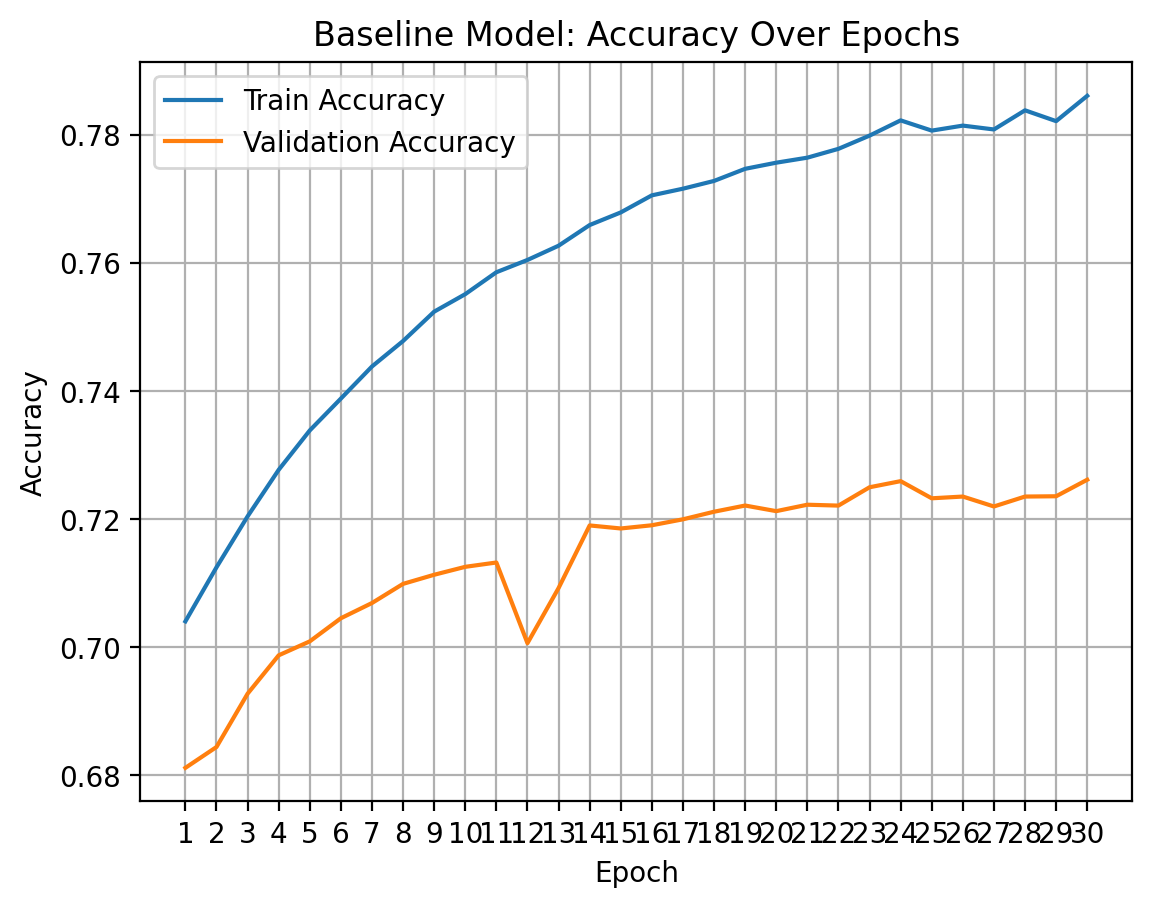

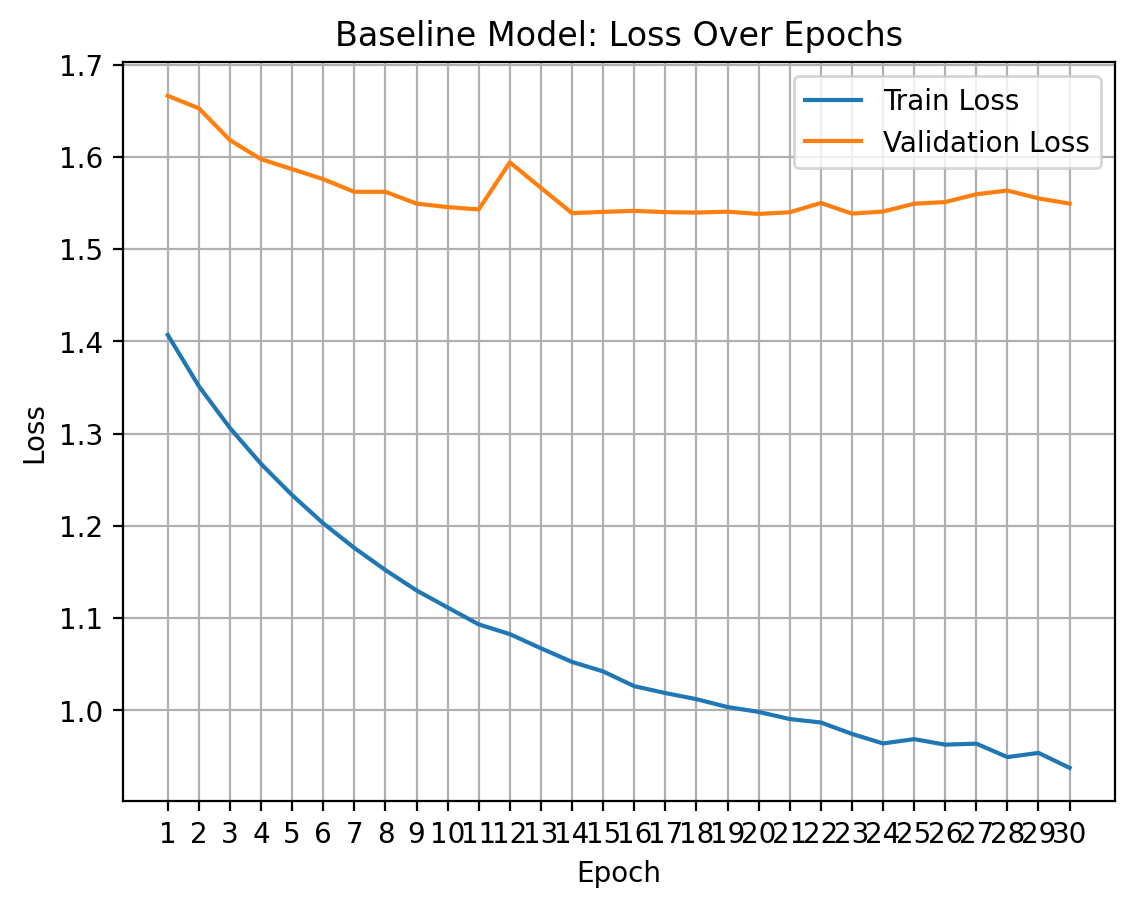

In [37]:
# Accuracy plot
epochs = list(range(1, len(history.history['accuracy']) + 1))
plt.plot(epochs,history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs,history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model: Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs) 
plt.grid(True)
plt.show()

# Loss plot
plt.plot(epochs,history.history['loss'], label='Train Loss')
plt.plot(epochs,history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model: Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs) 
plt.grid(True)
plt.show()

Using our custom music generator, we are able to input our tokens to create an audio file generating our own music. 

In [38]:
from music21 import stream, note, chord
import numpy as np
import random

# Convert token id to music 21 streams
def decode_to_music21(token_ids, idx_to_token):

    output = stream.Stream() # Initialize a music21 stream to hold the result

    # Iterate through each token ID in the generated sequence
    for tok_id in token_ids:
        token = idx_to_token[tok_id]
        # Derive out all our tokens based on the formula we established for it earlier
        try:
            pitch_info, dur = token.split("_") # Split pitch and duration information
            dur = float(dur)

            # Chord Event Case
            if "." in pitch_info:
                pitches = [int(p) for p in pitch_info.split(".")]
                c = chord.Chord(pitches)
                c.quarterLength = dur
                output.append(c)

            # Single note event case 
            else:
                n = note.Note(pitch_info)
                n.quarterLength = dur
                output.append(n)
        except:
            continue # Contingency plan of just skipping
            
    return output

# Custom function to generate music
def generate_music(model, idx_to_token, seed_seq, max_tokens=200, temperature=1.0):
    generated = seed_seq.copy()
    current_seq = seed_seq[-128:] # Establish a window of 128

    # Iterate through
    for _ in range(max_tokens):
        # Pad or truncate input to length 128
        input_seq = current_seq[-128:]
        input_seq = np.array(input_seq).reshape(1, -1)

        # Predict the next token distribution
        preds = model.predict(input_seq, verbose=0)[0]

        # Apply temperature
        preds = np.log(preds + 1e-9) / temperature
        preds = np.exp(preds) / np.sum(np.exp(preds))

        # Sample from the distribution
        next_token = np.random.choice(len(preds), p=preds)
        generated.append(next_token)
        current_seq.append(next_token)

    return decode_to_music21(generated, idx_to_token)

In [39]:
# Pick a seed and generate music
seed = X_test[random.randint(0, len(X_test)-1)].tolist()
generated_stream = generate_music(model, idx_to_token, seed, max_tokens=200, temperature=1.0)

In [ ]:
from IPython.display import Audio
import tempfile
import pretty_midi

# Save to a temporary MIDI file
with tempfile.NamedTemporaryFile(suffix=".mid", delete=False) as tmp:
    midi_path = tmp.name
    generated_stream.write('midi', fp=midi_path)

# Convert MIDI to audio using pretty_midi
midi_data = pretty_midi.PrettyMIDI(midi_path)
audio_waveform = midi_data.synthesize()

# Audio
Audio(audio_waveform, rate=44100)

<a id="part4"></a>
# Final Model 

## Final Model Architecture

For our final model architecture, we built upon our base model GRU to expand to multiple bidirectional GRU units. In addition to GRU units, we incorporated a single-head attention layer to parallelize and contextualize our embedded tokens. At the output of our attention block, we added multiple dense layers with batch normalization and dropout to prepare the outputs for classifying the next generated token. Lastly, we incorporated a final output layer using softmax activation. 


In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, BatchNormalization, Attention, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling1D
MAX_VOCAB = len(token_to_idx)
EMBED_DIM = 128  
SEQ_LEN = 128

# Input layer
inputs = Input(shape=(SEQ_LEN,), name="input_tokens")

# Embedding
x = Embedding(input_dim=MAX_VOCAB, output_dim=EMBED_DIM, input_length=SEQ_LEN)(inputs)

# First GRU 
x = Bidirectional(GRU(128, return_sequences=True))(x)

# Second GRU 
x = Bidirectional(GRU(128, return_sequences=True))(x)

# Attention block
attention_output = Attention(name="attention_layer")([x, x])  
x = Concatenate()([x, attention_output])  
x = GlobalAveragePooling1D()(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Final classification
x = Dense(MAX_VOCAB, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x, name="gru_with_attention")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "gru_with_attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_tokens (InputLayer)   [(None, 128)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 128, 128)             631296    ['input_tokens[0][0]']        
                                                                                                  
 bidirectional_4 (Bidirecti  (None, 128, 256)             198144    ['embedding_4[0][0]']         
 onal)                                                                                            
                                                                                                  
 bidirectional_5 (Bidirecti  (None, 128, 256)             296448    ['bidirection

Throughout our training, we incorporated early stopping and a learning rate scheduler, which would decrease the learning rate if performance decreases or plateaus. 


In [42]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


dataset = pipeline(X_train,y_train)
test_dataset = pipeline(X_test, y_test)
history = model.fit(dataset,
    validation_data=test_dataset,
    epochs=50,
    batch_size=64,
    callbacks=[lr_schedule, early_stop]
)
model.save_weights('model/final_model')

Epoch 1/50


W0000 00:00:1746835678.472317   19269 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA L4" frequency: 2040 num_cores: 58 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8800" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 50331648 shared_memory_size_per_multiprocessor: 102400 memory_size: 21771649024 bandwidth: 300048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6859/6859 [==============================] - ETA: 0s - loss: 2.7408 - accuracy: 0.5272

W0000 00:00:1746835799.006248   19269 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA L4" frequency: 2040 num_cores: 58 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8800" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 50331648 shared_memory_size_per_multiprocessor: 102400 memory_size: 21771649024 bandwidth: 300048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6859/6859 [==============================] - 134s 19ms/step - loss: 2.7408 - accuracy: 0.5272 - val_loss: 1.9652 - val_accuracy: 0.6198 - lr: 0.0010
Epoch 2/50
6859/6859 [==============================] - 108s 16ms/step - loss: 1.8645 - accuracy: 0.6392 - val_loss: 1.7465 - val_accuracy: 0.6661 - lr: 0.0010
Epoch 3/50
6859/6859 [==============================] - 107s 16ms/step - loss: 1.6103 - accuracy: 0.6812 - val_loss: 1.5481 - val_accuracy: 0.7025 - lr: 0.0010
Epoch 4/50
6859/6859 [==============================] - 107s 15ms/step - loss: 1.4342 - accuracy: 0.7130 - val_loss: 1.4539 - val_accuracy: 0.7253 - lr: 0.0010
Epoch 5/50
6859/6859 [==============================] - 107s 15ms/step - loss: 1.3121 - accuracy: 0.7343 - val_loss: 1.3794 - val_accuracy: 0.7414 - lr: 0.0010
Epoch 6/50
6859/6859 [==============================] - 106s 15ms/step - loss: 1.2143 - accuracy: 0.7509 - val_loss: 1.3466 - val_accuracy: 0.7504 - lr: 0.0010
Epoch 7/50
6859/6859 [=============================

Our model was originally meant to train for 50 epochs, but trained for 22 epochs total due to early stopping. We observe a final validation accuracy of 81.71%, which significantly outperforms our base model. 

## Final Model Results

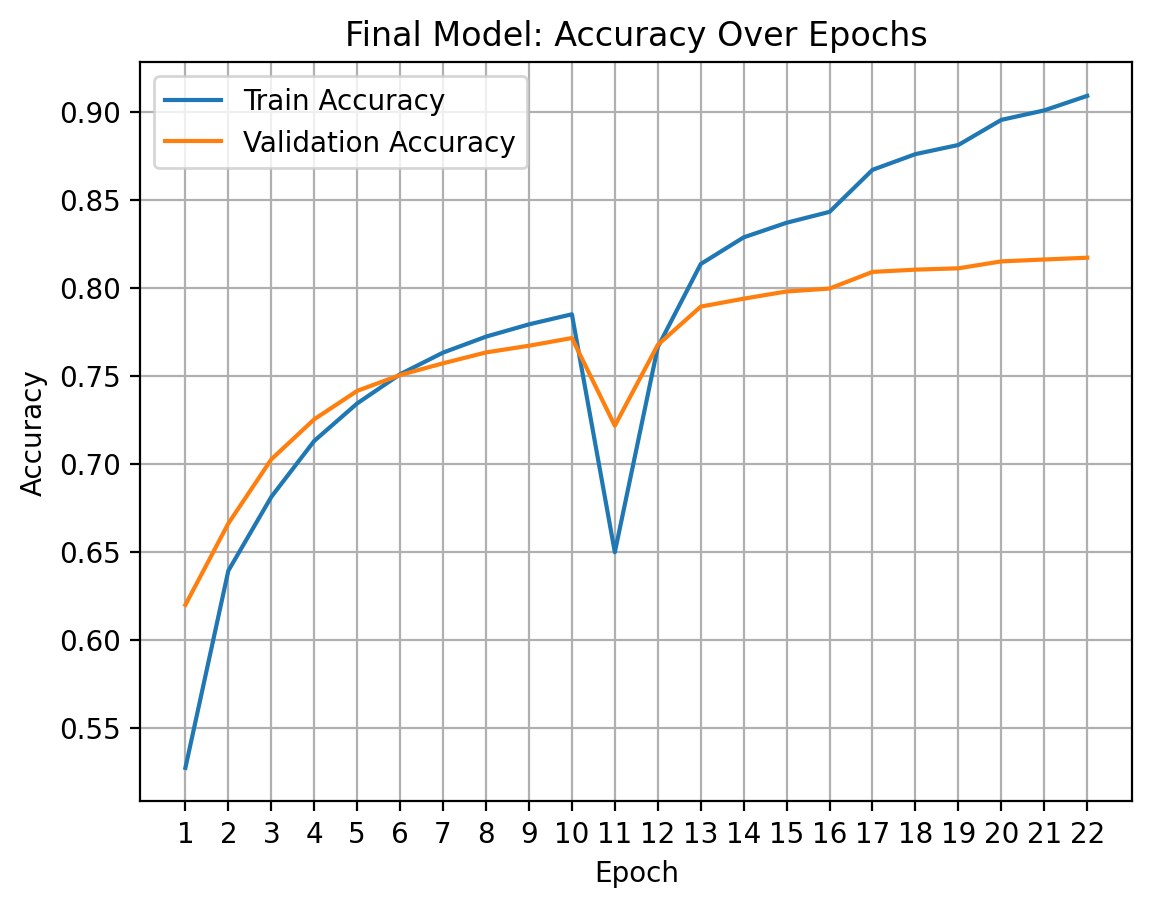

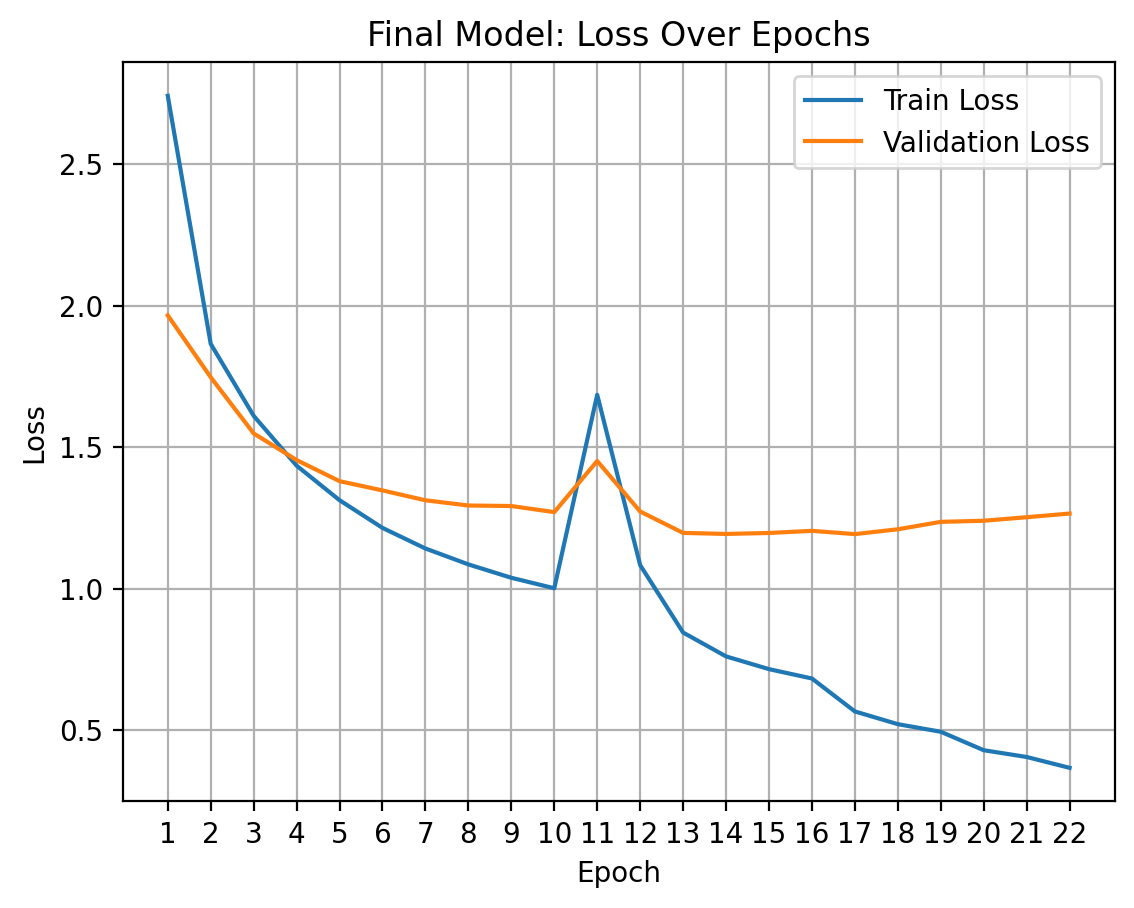

In [44]:
# Accuracy plot
epochs = list(range(1, len(history.history['accuracy']) + 1))
plt.plot(epochs,history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs,history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model: Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs) 
plt.grid(True)
plt.show()

# Loss plot
plt.plot(epochs,history.history['loss'], label='Train Loss')
plt.plot(epochs,history.history['val_loss'], label='Validation Loss')
plt.title('Final Model: Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs) 
plt.grid(True)
plt.show()

From the graphs above, we observe a slight decrease in accuracy and slight increase in loss around the 11th epoch from which our model was able to recover. 

With our trained model, we outputted predictions based on a selected seed from the test dataset. The predicted tokens would then be converted to musical notes using the music21 library, which would then convert the predictions into a playable music file. 

In [51]:
# Pick a seed and generate music
seed = X_test[random.randint(0, len(X_test)-1)].tolist()
generated_stream = generate_music(model, idx_to_token, seed, max_tokens=200, temperature=0.7)

In [ ]:
from IPython.display import Audio
import tempfile
import pretty_midi

# Save to a temporary MIDI file
with tempfile.NamedTemporaryFile(suffix=".mid", delete=False) as tmp:
    midi_path = tmp.name
    generated_stream.write('midi', fp=midi_path)

# Convert MIDI to audio using pretty_midi
midi_data = pretty_midi.PrettyMIDI(midi_path)
audio_waveform = midi_data.synthesize()

# Audio
Audio(audio_waveform, rate=44100)

From this generated audio file, we are able to hear a consistent melody, while lacking most of the structure found within today's pop music. The generated audio seems to be playing from MIDI's default instrument. 

<a id="part5"></a>
# Future Work and Improvement

Regardless of the resulting generated MIDI files, we acknowledge that multiple improvements could be made to our model and data preprocessing to achieve higher accuracies and output higher-quality music. 

1. **Outsourcing tokenizers**: While we manually tokenized our MIDI files using music21’s library, multiple sources online such as MIDItok provide MIDI file tokenizers that can be trained using techniques including byte-pair encoding. However, these resources were not available on the current version of the GPU cluster, and thus could not be utilized when training our model on the same cluster.  
2.	**Alternative MIDI file extraction:**  Another improvement would be to approach MIDI file extraction in a different way, as a large number of MIDI files could not be processed with imported packages. If we could better diagnose or transform the MIDI files, we could perhaps organize a larger dataset for the model.
3.	**Model fine-tuning limitations:** Lastly, due to memory constraints, we were not able to use external transformers or models to fine-tune our MIDI dataset. Models like GPT-2 resulted in exceeding GPU memory, and we were not able to fully train a model with this limitation. Had we had more time or computing resources, we could have taken advantage of Hugging Face’s library of models for better music generation.